# Load the data and data cleaning

In [1]:
# Load all the standard libraries for data analysis

import pandas as pd
import numpy as np

from scipy.stats import ttest_ind_from_stats
from scipy.stats import norm, beta

import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.style.use('ggplot')


# Load the data sets and remove duplicates if there are any.

Df_Sample = pd.read_csv('testSamples.csv')
Df_Sample = Df_Sample.drop_duplicates()

# There is nothing interesting in Df_Sample apart from the connexion between sample_id and 
# test_group. I'll use Df_sample to link the sample_id's to their respective test_group in Df_trans

Df_Trans = pd.read_csv('transData.csv')
Df_Trans = Df_Trans.drop_duplicates()

We can see that there are several transactions per sample_id. To make the analysis easier, I'm conbining the two data sets using the merge function. I'm taking the sample_id column as reference for both dataframe. From that, I can add the "test_group" column of testSample.csv to the transData.csv file, but only for the sample_id appearing in transData.

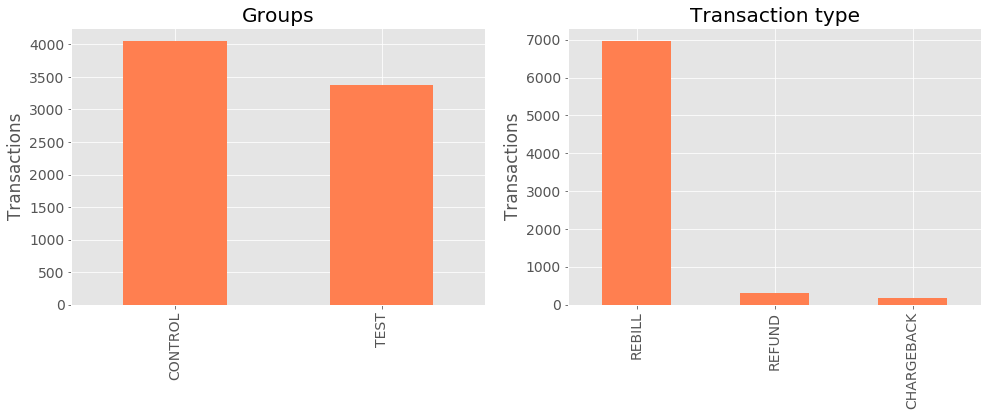

In [2]:
# The variable name "Df_combine_temp" is not optimal, but it is really just a temporary variable.
# I'm not doing anything with it, except from the plot below. 

Df_combine_temp = pd.merge(Df_Trans,
                 Df_Sample[['sample_id','test_group']],
                 on='sample_id')

rcParams.update({'font.size': 14})

# Plotting the different populations contained in Df_combine_temp

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14,6))
Df_combine_temp['test_group'].value_counts().plot(ax = axes[0], kind='bar',
                                       color="coral", fontsize=14,
                                       title = 'Groups');
axes[0].set_xticklabels(['CONTROL', 'TEST'])
axes[0].set_ylabel('Transactions')

Df_combine_temp['transaction_type'].value_counts().plot(ax = axes[1],kind='bar',
                                             color="coral", fontsize=14,
                                            title = 'Transaction type');
axes[1].set_ylabel('Transactions')
plt.tight_layout()
plt.savefig('TotalTransactions.png', dpi=200)
plt.show()



* First, by looking at the left Figure, we can see that the number of transaction in the control group is similar to this of the test group.
* Second, We see that no matter the group the population belongs to, they are more likely to generate at least 1  REBILL, rather than requiring a chargeback.
* By looking at Df_combine_temp, I've noticed that the transaction_amount for a given sample_id is always the same. Thus, we can group the transaction_amount in order to obtain a single line summing up a sample_id transactions. I'm also adding an extra column call "total_expense" which is defined as the product between the transaction_amount and counts columns.

In [3]:
# we count the number of transaction for each unique user in sample_id and we create a new column called "counts".

Df_combine = Df_combine_temp.groupby(['sample_id', 'test_group', 'transaction_type', 'transaction_amount'])\
                            .size().reset_index(name='counts')

# I'm separating the two groups, for clarity    
Control_Trans = Df_combine[Df_combine['test_group'] == 0]

# I add an extra column called "total_expense" = counts*transaction_amount
Control_Trans = Control_Trans.assign(total_expense=pd.Series(
    Control_Trans['transaction_amount'].mul(Control_Trans['counts'])).values
                                    )
Test_Trans = Df_combine[Df_combine['test_group'] == 1]
Test_Trans = Test_Trans.assign(total_expense=pd.Series(
    Test_Trans['transaction_amount'].mul(Test_Trans['counts'])).values
                                    )
Test_Trans.head() 

,sample_id,test_group,transaction_type,transaction_amount,counts,total_expense
0,11,1,REBILL,24.95,2,49.90
1,32,1,REBILL,29.95,4,119.80
6,137,1,REBILL,29.95,2,59.90
7,138,1,REBILL,24.95,1,24.95
8,249,1,REBILL,39.95,1,39.95


# Question 1

#### I'm now comparing the population of unique sample_ID who did either a REBILL, CASHBACK or REFUND. I'm also plotting that in a hist chart to get a visual. 

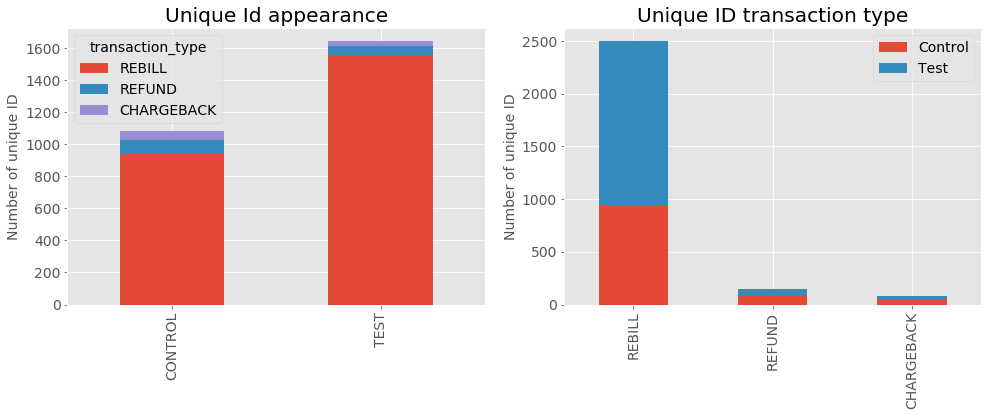

In [4]:
# I'm creating a small dataframe with all the relative population (Control/Test and Rebill/Refund/Chargeback).
# From that, I can extract the group distributions. 

Group_Trans_Compare = pd.DataFrame(np.array([[Control_Trans['transaction_type'].value_counts()[i],
                                              Test_Trans['transaction_type'].value_counts()[i]]
                                             for i in range(0,3)]),
                                   columns = ['Control','Test']
                       )

Group_Trans_Compare.insert(0, 'transaction_type', ['REBILL','REFUND','CHARGEBACK'])

# Useful for the left plot (distribution of Control and test group).
GTC_transpose = Group_Trans_Compare.set_index('transaction_type').T

fig2, axes = plt.subplots(nrows=1, ncols=2,figsize=(14,6))
GTC_transpose.plot(ax = axes[0], kind='bar', stacked = True, fontsize=14, title = 'Unique Id appearance');
axes[0].set_xticklabels(['CONTROL', 'TEST'])
axes[0].set_ylabel('Number of unique ID', fontsize=14)
Group_Trans_Compare.plot(ax = axes[1], kind = 'bar', stacked = True, title = 'Unique ID transaction type', fontsize=14)
axes[1].set_ylabel('Number of unique ID', fontsize=14)
axes[1].set_xticklabels(['REBILL','REFUND','CHARGEBACK'])

plt.tight_layout()
plt.savefig('CompareUniqueID.png', dpi=200)

plt.show()

In [5]:
Group_Trans_Compare

,transaction_type,Control,Test
0,REBILL,941,1556
1,REFUND,88,58
2,CHARGEBACK,53,29


**Quick Conclusion**: The group control represent $40\%$ of the unique sample_id population and $60\%$ are represented in the test group. 

# Question 2 : Is a user that must call-in to cancel more likely to generate at least 1 addition REBILL?
* We can get a quick overview of our data sets by using the describe function. I'm especially interested in the mean value and std of the "counts" column. 

In [6]:
Test_Summary = Test_Trans[['transaction_amount','counts','total_expense']].describe()
Test_Summary.iloc[1:3]

,transaction_amount,counts,total_expense
mean,28.269355,2.057212,58.084906
std,15.385725,1.448386,54.921052


In [7]:
Control_Summary = Control_Trans[['transaction_amount','counts','total_expense']].describe()
Control_Summary.iloc[1:3]

,transaction_amount,counts,total_expense
mean,19.308688,3.743068,83.030407
std,18.148325,3.336587,103.187736


Now, I'd like to see how many time the "REBILL" population of the two groups actually renew their subscription.
To do that, I will create two new variables, "ControlCountRebill" and "TestCountRebill", which will answer the question "how many time do they renew their subscription".

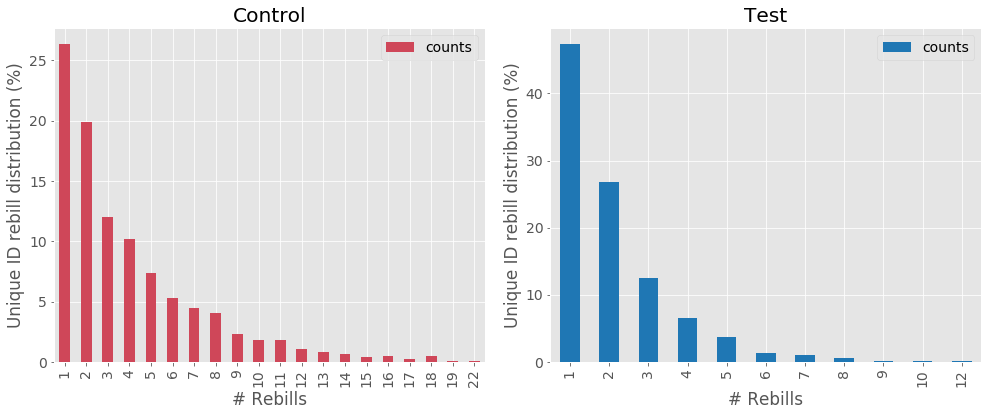

In [8]:
# Variables definitions

ControlCountRebill = pd.DataFrame([Control_Trans['counts'][Control_Trans['transaction_type'] == 'REBILL'].value_counts().sort_index()]).T
ControlCountRebill /= ControlCountRebill.sum() #normalization
ControlCountRebill*=100 # express the results in %

TestCountRebill = pd.DataFrame([Test_Trans['counts'][Test_Trans['transaction_type'] == 'REBILL'].value_counts().sort_index()]).T
TestCountRebill /= TestCountRebill.sum()
TestCountRebill*=100

# Plotting part
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14,6))
ControlCountRebill.plot(ax = axes[0], kind = 'bar',
                             color = '#cf4759',fontsize = 14,
                             title = 'Control');
axes[0].set_xlabel('# Rebills')
axes[0].set_ylabel('Unique ID rebill distribution (%)')

TestCountRebill.plot(ax = axes[1], kind ='bar', color ="#1f77b4", fontsize = 14, title = 'Test');
axes[1].set_xlabel('# Rebills')
axes[1].set_ylabel('Unique ID rebill distribution (%)')

plt.tight_layout()
plt.savefig('RebillDistribution.png', dpi=200)

plt.show()


From this figure, we can see that the shape of the two distributions are similar, i.e between an exponential decay and a Poisson law. This means that most of the time, people will only do one or two rebills. 

However, we can notice that the control group is more likely to rebill several time (up to 22 times) than the test group (12 times max).

To answer the second question properly, I tried to use a bayesian approach. This is oftenly used in A/B testing. 

It enables several things:
1. Get the conversion rate of the two population using a Monte-Carlo simulation applied on a beta distribution.
2. It offers a good visualization of the mean/conversion rate and the possible deviation from the mean value.
3. It offers an easy/visual way to understand if the test is statistically significant by looking at the overall overlap between the two distribution (see below)

Note: Prior is equal to one as there is "no past". People are put in a category randomly and also chosen randomly to check their transactions

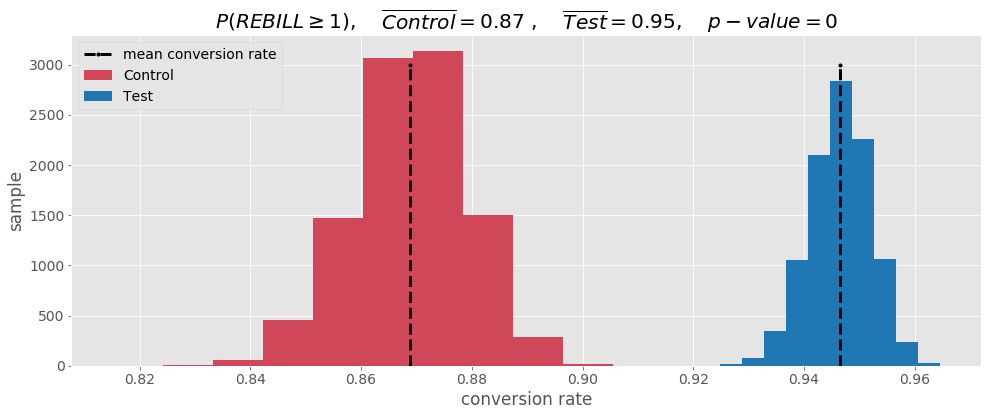

In [9]:
N_sample = 10000

prior_Cont = 1.0
prior_Test = 1.0

ControlPop = Group_Trans_Compare['Control'].sum() # Total population of the Control Group
TestPop = Group_Trans_Compare['Test'].sum() # same for Test group
Control_REBILL = Group_Trans_Compare['Control'][0] # Control group with at least 1 rebill
Test_REBILL = Group_Trans_Compare['Test'][0] # same for Test group

# Monte-Carlo like simulation ==> This will give us the mean conversion rate of the two groups

A_samples = np.random.beta(Control_REBILL+prior_Cont, ControlPop-Control_REBILL+prior_Cont, N_sample)
B_samples = np.random.beta(Test_REBILL+prior_Test, TestPop-Test_REBILL+prior_Test, N_sample)

# p-value calculation, determined by the overlap between the two beta distribution
p_value = 1-sum(B_samples > A_samples)/N_sample

# Plotting
plt.figure(figsize=(14,6))
plt.hist(A_samples, label = 'Control', color ='#cf4759')
plt.plot([A_samples.mean(), A_samples.mean()], [0, 3000], '.--', color = 'black', lw = 3, label = 'mean conversion rate')
plt.hist(B_samples, label = 'Test', color ="#1f77b4")
plt.plot([B_samples.mean(), B_samples.mean()], [0, 3000], '.--', color = 'black', lw = 3)
plt.xlabel('conversion rate')
plt.ylabel('sample')
plt.title('$P(REBILL \geq 1)$,    $\overline{Control} = %.2f$ ,    $\overline{Test} = %.2f$,    $p-value = 0$'\
          % (A_samples.mean(), B_samples.mean()))
plt.legend()
plt.tight_layout()
plt.savefig('Bayesian_Question2.png', dpi=200)
plt.show()


**Quick Conclusion**: People in the call-in group are 8% more likely to do at least 1 rebill. This test is statistically significant as the p-value is 0, which is < $\alpha = 0.05$ (standardized threshold value)

# 3. Is a user that must call-in to cancel more likely to generate more revenues?

So, here, I've just calculated the total expense for each people in sample_id. To do so, I've multiplied the "counts" (i.e the number of transactions they've done) by the "transaction_amount" (as I've said previously, the transaction amount for a unique sample_id is always the same). I've done that for the two dataframe (Control and Test) and I'm comparing the distribution of the total expense. It is not detailled below, but I've done different tests, using either a Normal or a Beta distribution and the Normal give better results. 

Ttest_indResult(statistic=7.3033732709958761, pvalue=4.5551156961474861e-13)


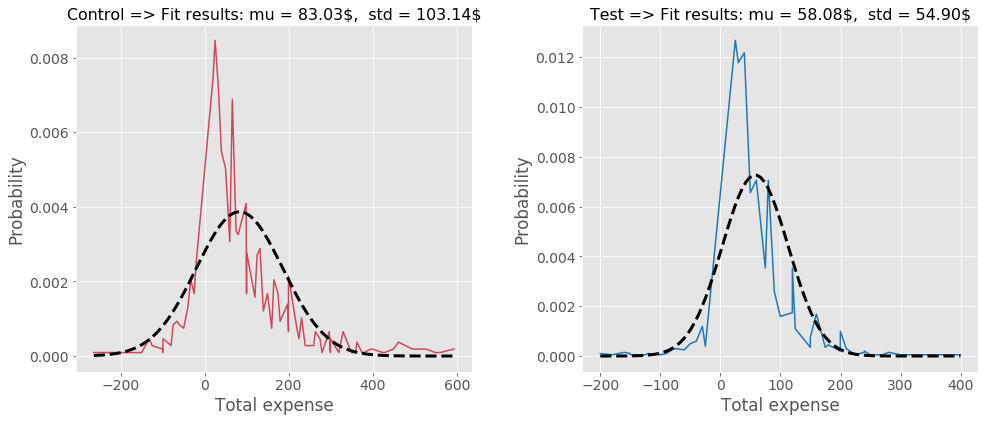

In [10]:
# Fit a normal distribution to the data and extract mean value and std.
TotExpCont = Control_Trans['total_expense']
TotExpTest = Test_Trans['total_expense']

MeanExpCont, StdExpCont = norm.fit(TotExpCont)
MeanExpTest, StdExpTest = norm.fit(TotExpTest)

# p-value
print(ttest_ind_from_stats(MeanExpCont, StdExpCont, ControlPop, MeanExpTest, StdExpTest, TestPop, equal_var=False))

#%% Starting from here, i'm just preparing the data to plot them properly...


# absciss and ordinate of a normal distribution using fit parameters obtained above. 

xControl = np.linspace(TotExpCont.min(), TotExpCont.max(), ControlPop)  
PDF_Control = norm.pdf(xControl, MeanExpCont, StdExpCont)  

xTest = np.linspace(TotExpTest.min(), TotExpTest.max(), 100)
PDF_Test = norm.pdf(xTest, MeanExpTest, StdExpTest) # normal distribution using fit parameters(Test group)

# Fancy titles
titleCont = "Control => Fit results: mu = %.2f\$,  std = %.2f\$" % (MeanExpCont, StdExpCont)
titleTest = "Test => Fit results: mu = %.2f\$,  std = %.2f\$" % (MeanExpTest, StdExpTest)

# preparation of the experimental datas for plotting, with normalization (integration of the whole function)
xExpCont = pd.DataFrame(Control_Trans['total_expense'].value_counts().sort_index())
yExpCont = pd.DataFrame(Control_Trans['total_expense'].value_counts().sort_index())['total_expense']
NormalizationExpCont = xExpCont.apply(np.trapz, axis=0, args=(xExpCont.index,))

xExpTest = pd.DataFrame(TotExpTest.value_counts().sort_index())
yExpTest = pd.DataFrame(TotExpTest.value_counts().sort_index())['total_expense']
NormalizationExpTest = xExpTest.apply(np.trapz, axis=0, args=(xExpTest.index,))


#%% plotting

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14,6))
rcParams.update({'font.size': 11})
axes[0].plot(xExpCont.index,yExpCont/NormalizationExpCont[0] , color = '#cf4759')
axes[0].plot(xControl, PDF_Control, '--', color = 'black', lw = 3)
axes[0].set_xlabel('Total expense')
axes[0].set_ylabel('Probability')
axes[0].set_title(titleCont)

axes[1].plot(xExpTest.index,yExpTest/NormalizationExpTest[0] , color = '#1f77b4')
axes[1].plot(xTest, PDF_Test, '--', color = 'black', lw = 3)
axes[1].set_xlabel('Total expense')
axes[1].set_ylabel('Probability')
axes[1].set_title(titleTest)
plt.tight_layout()
plt.savefig('CompareTotalExpense_question3.png', dpi=200)
plt.show()

**Quick conclusion** : We have a mean value of 83.03\$ and 58.08\$ for the control and test group respectively, meaning that on average, people from the control group are more likely to spend money than the Test one. 

**However**, the standard deviation of the Control group is twice the std of the Test group (103 and 55 respectively), meaning that, even if the test group spend less money on average, they are less likely to ask for refund/chargebacks in opposition with the control group.  

# Question 4 : Is a user that must call-in more likely to produce a higher chargeback rate(CHARGEBACKs/REBILLs)?

So, here, I got a bit confused with the definition of chargeback rate. In the question, we ask to calculare the chargeback rate defined as the number of chargeback over the number of rebills. I've been looking at the definition online and it appears that the charge back rate can also be defined as the number of chargeback over the total number of transaction (in our case : rebill + refund + chargeback). 

To take my decision, I've decided to compare the two cases. 

### Case 1 : #chargebacks/total transactions number

0.0038


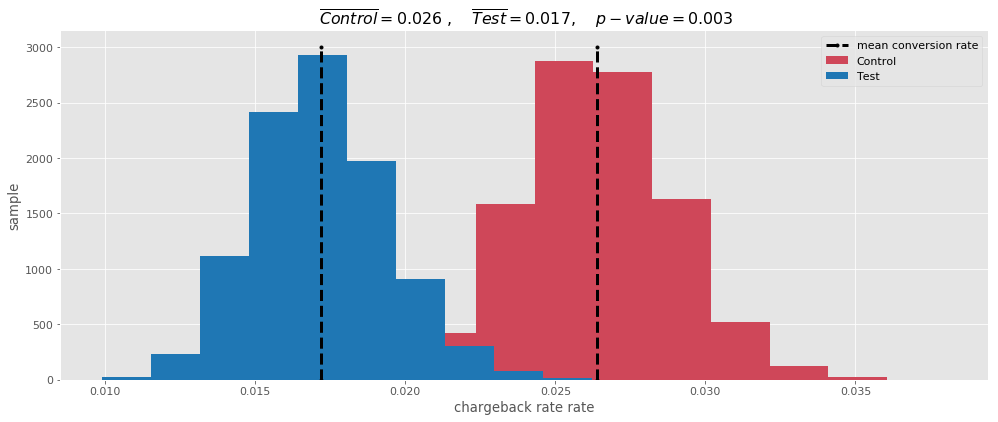

In [11]:
Cont_chargeback_cdt = Control_Trans['transaction_type'] == 'CHARGEBACK'
Test_chargeback_cdt = Test_Trans['transaction_type'] == 'CHARGEBACK'

N_sample = 10000

prior_Cont = 1.0
prior_Test = 1.0

ControlTotTransaction = Control_Trans['counts'].sum()  # Total number of transaction in control group
TestTotTransaction = Test_Trans['counts'].sum()  # same for Test group
Control_chargeback = Control_Trans['counts'][Cont_chargeback_cdt].sum() # number of chargebacks
Test_chargeback = Test_Trans['counts'][Test_chargeback_cdt].sum()  # same for Test group

# Monte-Carlo like simulation ==> This will give us the mean conversion rate of the two groups

A_samplesCR1 = np.random.beta(Control_chargeback+prior_Cont,
                              ControlTotTransaction-Control_chargeback+prior_Cont,
                              N_sample)

B_samplesCR1 = np.random.beta(Test_chargeback+prior_Test,
                              TestTotTransaction-Test_chargeback+prior_Test,
                              N_sample)

# p-value calculation, determined by the overlap between the two beta distribution
p_valueCR1 = 1-sum(B_samplesCR1 < A_samplesCR1)/N_sample  # notice the < sign, in opposition with question 2. 
print(p_valueCR1)

# Plotting
plt.figure(figsize=(14,6))
plt.hist(A_samplesCR1, label = 'Control', color ='#cf4759')
plt.plot([A_samplesCR1.mean(), A_samplesCR1.mean()], [0, 3000], '.--', color = 'black', lw = 3, label = 'mean conversion rate')
plt.hist(B_samplesCR1, label = 'Test', color ="#1f77b4")
plt.plot([B_samplesCR1.mean(), B_samplesCR1.mean()], [0, 3000], '.--', color = 'black', lw = 3)
plt.xlabel('chargeback rate rate')
plt.ylabel('sample')
plt.title(r' $\overline{Control} = %.3f$ ,    $\overline{Test} = %.3f$,    $p-value = 0.003$'\
          % (A_samplesCR1.mean(), B_samplesCR1.mean()))
plt.tight_layout()
plt.savefig('Bayesian_Question4_case1.png', dpi=200)
plt.legend()
plt.show()


### Case 2 : #chargebacks/#rebills

0.0024


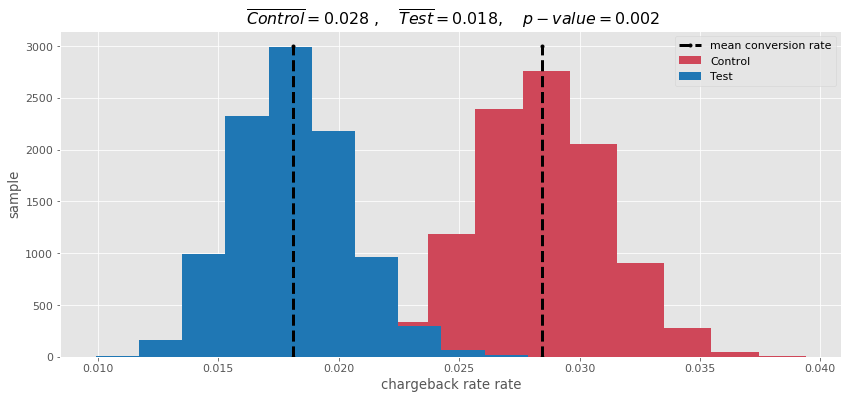

In [12]:
# Get number of rebills transaction for both groups
ControlTotTransaction = Control_Trans['counts'][Control_Trans['transaction_type'] == 'REBILL'].sum() 
TestTotTransaction = Test_Trans['counts'][Test_Trans['transaction_type'] == 'REBILL'].sum()

# Monte-Carlo like simulation ==> This will give us the mean conversion rate of the two groups

A_samplesCR2 = np.random.beta(Control_chargeback+prior_Cont, 
                              ControlTotTransaction-Control_chargeback+prior_Cont,
                              N_sample)
B_samplesCR2 = np.random.beta(Test_chargeback+prior_Test,
                            TestTotTransaction-Test_chargeback+prior_Test,
                            N_sample)

# p-value calculation, determined by the overlap between the two beta distribution
p_value2 = 1-sum(B_samplesCR2 < A_samplesCR2)/N_sample
print(p_value2)

# Plotting
plt.figure(figsize=(14,6))
plt.hist(A_samplesCR2, label = 'Control', color ='#cf4759')
plt.plot([A_samplesCR2.mean(), A_samplesCR2.mean()], [0, 3000],
         '.--', color = 'black', lw = 3, label = 'mean conversion rate')

plt.hist(B_samplesCR2, label = 'Test', color ="#1f77b4")
plt.plot([B_samplesCR2.mean(), B_samplesCR2.mean()], [0, 3000],
         '.--', color = 'black', lw = 3)

plt.xlabel('chargeback rate rate')
plt.ylabel('sample')
plt.title(r' $\overline{Control} = %.3f$ ,    $\overline{Test} = %.3f$,    $p-value = 0.002$'\
          % (A_samplesCR2.mean(), B_samplesCR2.mean()))
plt.legend()
plt.savefig('Bayesian_Question4_case2.png', dpi=200)
plt.legend()
plt.show()

**Quick Conclusion**: 
* No major differences between the two cases ($\Delta(\text{chargeback rate}) \approx 0.1\%-0.2 \%$), so both are relevants. 
* The chargeback rate of the test group is clearly inferior to the control group one, by $\approx 1\%$. The Bayesian approach shows us one more time that this study is statistically significant, with a p-value of $\approx 0.002 < \alpha = 0.05$

##### Extra study to check the population distribution of the number of chargeback + refund. 

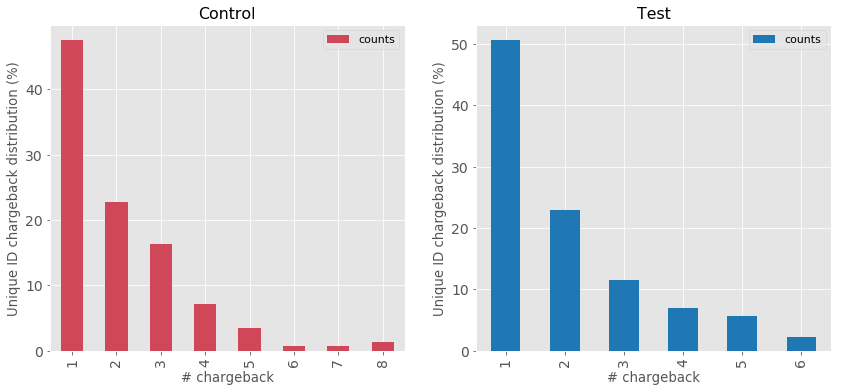

In [13]:
Cont_chargeback_cdt = (Control_Trans['transaction_type'] == 'CHARGEBACK') | (Control_Trans['transaction_type'] == 'REFUND')
Test_chargeback_cdt = (Test_Trans['transaction_type'] == 'CHARGEBACK') | (Test_Trans['transaction_type'] == 'REFUND')

ControlCountChargeback = pd.DataFrame(Control_Trans['counts'][Cont_chargeback_cdt].value_counts().sort_index())
ControlCountChargeback/=ControlCountChargeback.sum()
ControlCountChargeback*=100

TestCountChargeback = pd.DataFrame(Test_Trans['counts'][Test_chargeback_cdt].value_counts().sort_index())
TestCountChargeback /= TestCountChargeback.sum()
TestCountChargeback *= 100

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14,6))

ControlCountChargeback.plot(ax = axes[0], kind = 'bar', color = '#cf4759', fontsize = 14, title = 'Control')
axes[0].set_xlabel('# chargeback')
axes[0].set_ylabel('Unique ID chargeback distribution (%)')
TestCountChargeback.plot(ax = axes[1], kind = 'bar', color = '#1f77b4', fontsize = 14, title = 'Test')
axes[1].set_xlabel('# chargeback')
axes[1].set_ylabel('Unique ID chargeback distribution (%)')
plt.show()